In [1]:
import sys
path = '/gpfs/commons/groups/gursoy_lab/mstoll/'
sys.path.append(path)

import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import pickle
import time
import os
import shutil
import shap
import seaborn as sns
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import LambdaLR, LinearLR, SequentialLR
from functools import partial
from sklearn.metrics import f1_score, accuracy_score
from sklearn.calibration import calibration_curve


from codes.models.metrics import calculate_roc_auc
from codes.models.data_form.DataForm import DataTransfo_1SNP, PatientList, Patient
from codes.models.Transformers.dic_model_versions import DIC_MODEL_VERSIONS
from codes.tests.TestsClass import TestSet, TrainTransformerModel, TrainModel
import matplotlib.pyplot as plt
from codes.models.Decision_tree.utils import get_name, get_indice



2024-02-22 17:56:07.773322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 17:56:07.773403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 17:56:07.775275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 17:56:19.853337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
train_model =  TrainModel.load_instance_test(253)
model = train_model.model
dataT = train_model.dataT
model.device = 'cpu'
patient_list = train_model.patient_list
data = train_model.dataT
nb_max_distinct_disease = len(patient_list[0].diseases_sentence)
nb_max_distinct_diseases_tot = patient_list.get_nb_distinct_diseases_tot()

frequencies = np.zeros(nb_max_distinct_diseases_tot)
for patient in patient_list:
    frequencies[patient.diseases_sentence] +=1 
frequencies /= len(patient_list)

In [4]:
indices_train, indices_test = train_model.dataT.indices_train, train_model.dataT.indices_test
train_model.patient_list_transformer_train, train_model.patient_list_transformer_test = train_model.patient_list.get_transformer_data(indices_train.astype(int), indices_test.astype(int))
#creation of torch Datasets:
dataloader_train = DataLoader(train_model.patient_list_transformer_train, batch_size=train_model.batch_size, shuffle=True)
dataloader_test = DataLoader(train_model.patient_list_transformer_test, batch_size=train_model.batch_size, shuffle=True)



In [5]:
def get_gpu_attributes(obj, prefix=''):
    """
    Fonction récursive pour obtenir les noms des attributs stockés sur GPU.
    """
    gpu_attributes = []
    if isinstance(obj, torch.Tensor) and obj.is_cuda:
        gpu_attributes.append(prefix)
    elif isinstance(obj, (list, tuple)):
        for i, item in enumerate(obj):
            gpu_attributes.extend(get_gpu_attributes(item, prefix=f"{prefix}[{i}]"))
    elif isinstance(obj, dict):
        for key, value in obj.items():
            gpu_attributes.extend(get_gpu_attributes(value, prefix=f"{prefix}.{key}"))
    elif hasattr(obj, '__dict__'):
        for key, value in obj.__dict__.items():
            gpu_attributes.extend(get_gpu_attributes(value, prefix=f"{prefix}.{key}"))
    return gpu_attributes

# Exemple d'objet avec des attributs stockés sur CPU et GPU
class ExempleObjet:
    def __init__(self):
        self.cpu_tensor = torch.randn(3, 3)
        self.gpu_tensor = torch.randn(3, 3).cuda()

   


In [6]:
get_gpu_attributes(train_model)

[]

### Calibration plots

beginning inference evaluation


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num classes = 2
end inference evaluation in 9.566430568695068s


(array([10., 11.,  7., 10., 11.,  8., 13.,  9.,  8.,  6., 14., 19., 11.,
        17., 12., 13., 18., 15., 14., 22., 15., 13., 17., 17., 18., 15.,
        21., 34., 19., 54., 24., 25., 28., 47., 36., 25., 34., 31., 57.,
        39., 56., 47., 41., 40., 42., 27., 27., 32., 39., 32., 32., 43.,
        32., 35., 40., 74., 38., 31., 29., 51., 41., 34., 37., 32., 23.,
        27., 32., 33., 59., 21., 32., 31., 33., 34., 18., 25., 22., 21.,
        23., 23., 23., 19., 22., 22., 17., 20., 15., 15., 10., 16., 11.,
        11.,  8., 13.,  3., 10.,  6., 12.,  4.,  7.]),
 array([0.01068728, 0.02023493, 0.02978257, 0.03933022, 0.04887786,
        0.0584255 , 0.06797315, 0.0775208 , 0.08706844, 0.09661608,
        0.10616373, 0.11571137, 0.12525901, 0.13480666, 0.1443543 ,
        0.15390195, 0.16344959, 0.17299724, 0.18254489, 0.19209252,
        0.20164017, 0.21118781, 0.22073546, 0.2302831 , 0.23983075,
        0.2493784 , 0.25892603, 0.26847368, 0.27802134, 0.28756896,
        0.29711661, 0.3066

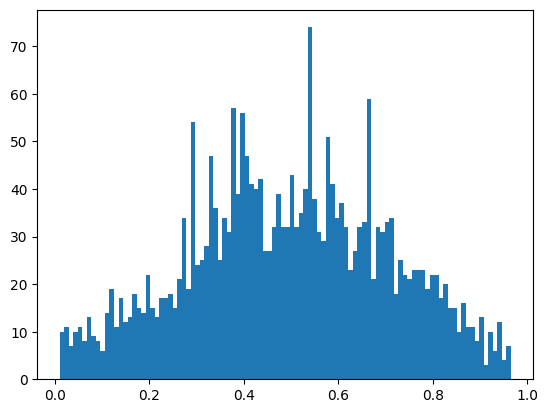

In [12]:
################################## Calibration plots ##############################################################
f1, accuracy, auc_score, loss, proba_avg_zero, proba_avg_one, predicted_probas_list, true_labels_list = model.evaluate(dataloader_test)
predicted_probs_ones = np.array(predicted_probas_list)[:, 1]
true_labels = np.array(true_labels_list)
plt.hist(predicted_probs_ones, bins=100)

num classes = 2


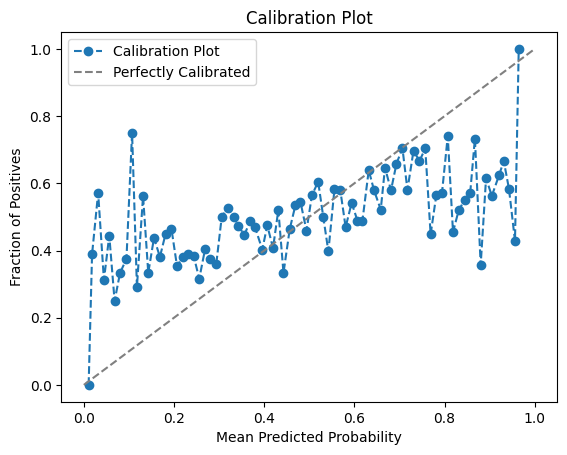

In [13]:
prob_true, prob_pred = calibration_curve(true_labels_list, predicted_probs_ones, n_bins=80)
auc = calculate_roc_auc(true_labels_list, predicted_probs_ones)
# Tracer le graphique de calibration
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', label='Calibration Plot')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()

In [14]:
auc_score

0.5800985562092313

### Analyse of the number of diseases

In [15]:
list_diseases, list_counts, list_labels = zip(*train_model.patient_list_transformer_train)
list_diseases = np.array(list_diseases)
list_counts = np.array(list_counts)
list_labels = np.array(list_labels)

nb_diseases = np.sum(list_diseases !=0, axis=1)
predicted_labels = (predicted_probs_ones > 0.5).astype(int)

In [233]:
acc = []
for nb_disease in np.unique(nb_diseases):
    indices = nb_diseases == nb_disease
    true = true_labels[indices]
    pred = predicted_labels[indices]
    acc.append(np.sum(true==pred)/len(true))

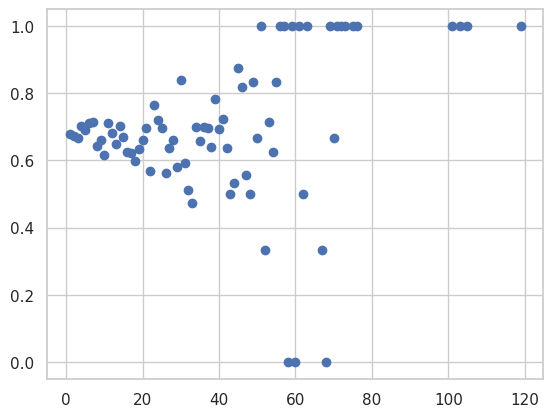

In [234]:
plt.plot(np.unique(nb_diseases),  acc, 'o')

### Analyse of the well predicted patients

In [235]:
list_diseases, list_counts, list_labels = zip(*train_model.patient_list_transformer_train)
list_diseases = np.array(list_diseases)
list_counts = np.array(list_counts)
list_labels = np.array(list_labels)

In [236]:
indices_predicted_low = predicted_probs_ones<0.45

In [237]:
patients_selected = list_diseases[indices_predicted_low]

In [246]:
np.sum(indices_predicted_low)

4185

In [247]:
frequencies_selected = np.zeros(nb_max_distinct_diseases_tot)
for disease_sentence in patients_selected:
    frequencies_selected[disease_sentence] += 1
frequencies_selected /= np.sum(indices_predicted_low)

In [248]:
frequencies_ratio = np.abs(frequencies - frequencies_selected)/frequencies
#diff_frequencies =np.max(np.concatenate([frequencies_ratio,  frequencies_ratio**-1], axis=0).reshape(2, len(frequencies_ratio)), axis=0)


In [249]:
#diff_frequencies = diff_frequencies[diff_frequencies!=np.inf]


In [250]:
np.argmax(frequencies_ratio)

382

In [251]:
frequencies_ratio[15], frequencies[15], frequencies_selected[15]*2330

(1.0, 8.098477486232588e-05, 0.0)

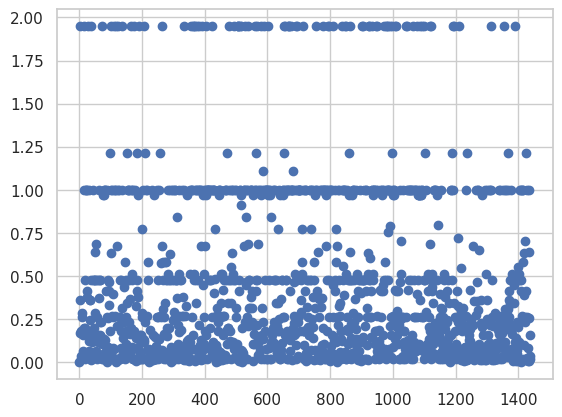

In [252]:
plt.plot(frequencies_ratio, 'o')

### Shap values

In [253]:
batch_sentence, batch_counts, batch_labels = next(iter(dataloader_test))
batch_sentence = batch_sentence
batch_counts = batch_counts
input_data = [batch_sentence.to(torch.float), batch_counts.to(torch.float)]
shap_input = [batch_sentence.to(torch.float)[0].view(1, 122), batch_counts.to(torch.float)[0].view(1, 122)]


In [245]:
model.shap=True

In [ ]:
batch_counts

In [ ]:
explainer = shap.DeepExplainer(model, input_data)


In [ ]:
shap_values = explainer.shap_values(shap_input)


In [ ]:
shap_values

### Clustering patients


### Attention visualization

In [254]:
diseases_batch, counts_batch, labels_batch = next(iter(dataloader_test))

In [255]:
logits, probas, x_out = model.forward_decomposed(diseases_batch, counts_batch)


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [256]:
indice = 9
torch.sum(model.padding_mask[indice][0]==1), torch.sum(diseases_batch[indice]!=0)

(tensor(40), tensor(40))

In [257]:
attention_probas_raw = model.list_attention_layers
attention_probas_list = []
for attention_probas in attention_probas_raw:
    attention_probas_list.append(attention_probas.detach().numpy())


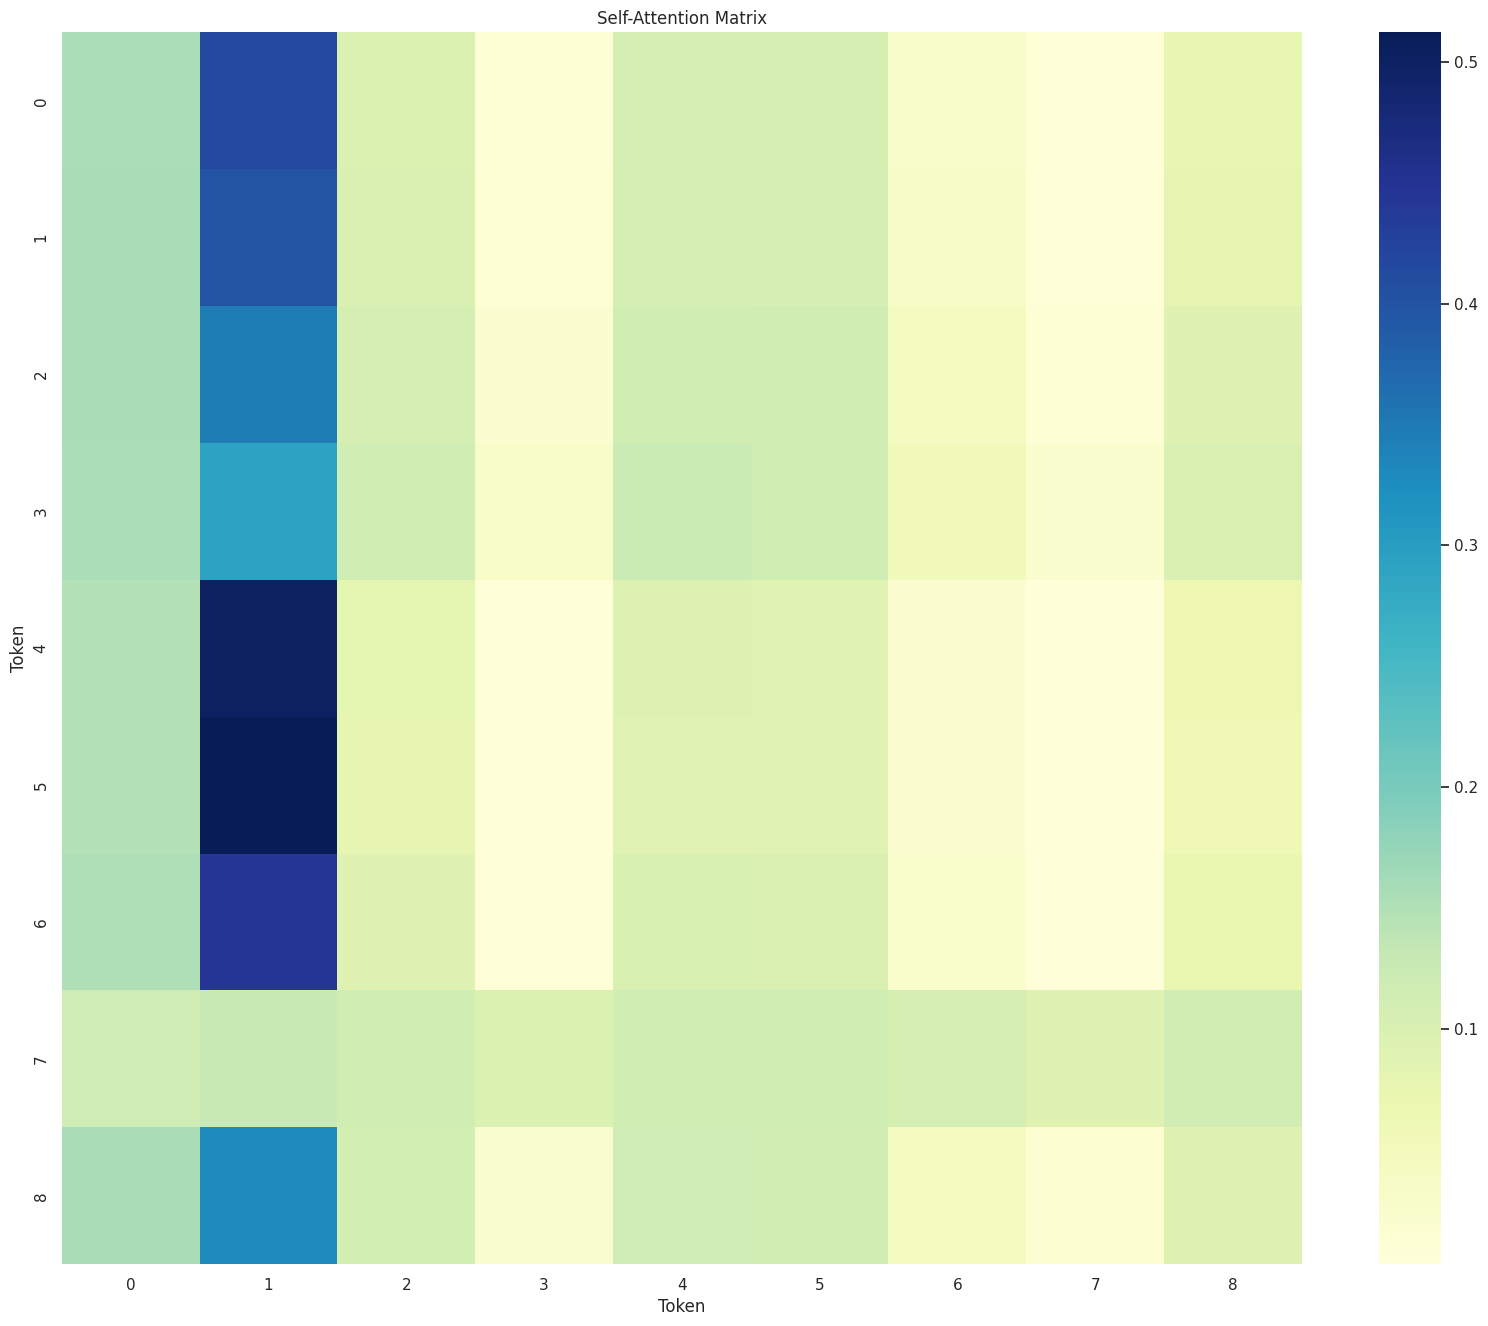

In [258]:
indice_sentence = 1
indice_layer = 0
indice_head = 1

attention_probas = attention_probas_list[indice_layer][indice_sentence][indice_head]
mask = model.padding_mask.detach().numpy()[indice_sentence].astype(bool)
n_real = np.sum(mask[0])

attention_probas_masked = attention_probas[mask].reshape(n_real, n_real)

sns.set(style="whitegrid")
plt.figure(figsize=(20, 16))
sns.heatmap(attention_probas_masked, cmap="YlGnBu", annot=False, fmt=".2f", cbar=True)

# Ajoutez des étiquettes pour les axes
plt.xlabel("Token")
plt.ylabel("Token")
plt.title("Self-Attention Matrix")

# Affichez le plot
plt.show()

In [263]:
## definition of the attention matrix:
nb_distinct_diseases_tot = patient_list.get_nb_distinct_diseases_tot()
res_matrix = np.zeros((nb_distinct_diseases_tot, nb_distinct_diseases_tot))
frequencies = np.zeros(nb_distinct_diseases_tot)
attention_score_diseases = np.zeros(nb_distinct_diseases_tot)


for batch_sentence, batch_counts, batch_labels in dataloader_train:
    logits, probas, x_out = model.forward_decomposed(diseases_batch, counts_batch)
    attention_probas_raw = model.list_attention_layers
    ## change to numpy
    attention_probas_list = []
    for attention_probas in attention_probas_raw:
        attention_probas_list.append(attention_probas.detach().numpy())

    for indice_layer in range(train_model.n_layer):
        for indice_head in range(train_model.n_head):
            for indice_sentence in range(len(batch_sentence)):
                sentence = diseases_batch[indice_sentence]
                attention_probas = attention_probas_list[indice_layer][indice_sentence][indice_head]
                mask = model.padding_mask.detach().numpy()[indice_sentence].astype(bool)
                n_real = np.sum(mask[0])
                sentence = sentence[:n_real]

                mask_mat = np.zeros_like(res_matrix, dtype=bool)
                mask_mat[np.ix_(sentence, sentence)] = True

                
                frequencies[sentence] +=1
                attention_probas_masked = attention_probas[mask]
                res_matrix[mask_mat] = res_matrix[mask_mat] + attention_probas_masked



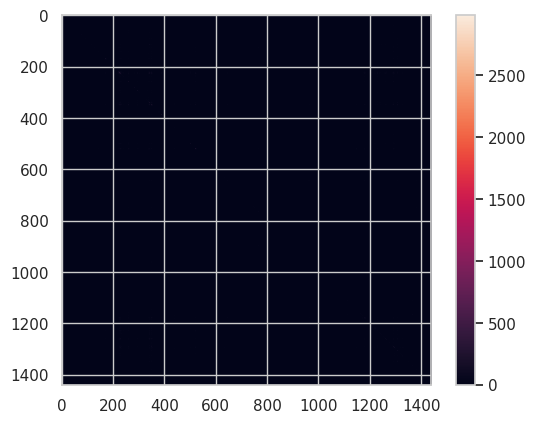

In [268]:
plt.imshow(res_matrix)
plt.colorbar()

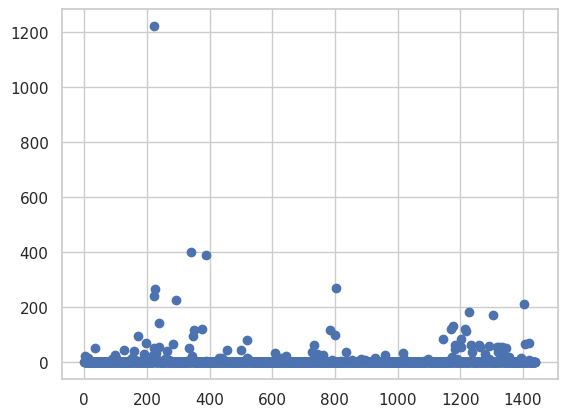

In [285]:
plt.plot(res_matrix[223], 'o')

In [287]:
indices = np.argsort(res_matrix[223])[::-1]

In [288]:
get_name(dataT, indices, decal=False)

['Asthma',
 'Heart Disease',
 'Type 2 Diabetes',
 'Polyp',
 'Hypertensive Disorder/Complications',
 '[P] Alcohol Use Disorder',
 'Cataract',
 '[P] Gastrointestinal bleeding with inpatient admission',
 '[P][R] Gastritis',
 '[P][R] Renal impairment',
 '[P] Pleural Effusion',
 'Disorder of free lower limb',
 '[P][R] Hypothyroidism',
 '[P] Uterine Fibroids or benign uterine tumors',
 'Injury of lower leg',
 'Osteoarthritis',
 'Closed fracture of lower limb',
 '[P][R] Gastrointestinal hemorrhage',
 'Musculoskeletal and connective tissue disorder',
 'Gastroesophageal Reflux Disease',
 '[P] Tinnitus',
 'Disorder of tendon',
 '[P][R] Lichen planus',
 'Disorder of soft tissue of upper limb',
 '[W] Autoimmune condition (FP)',
 'Acquired deformity of toe',
 '[P] Iron deficiency Anemia',
 'Cardiac arrhythmia',
 '[P][R] Urinary tract infectious disease',
 '[P][R] Edema',
 'Injury of free lower limb',
 '[P][R] Sleep apnea',
 'Localized enlarged lymph nodes',
 '[P][R] Malignant neoplastic disease',
 

In [289]:
## definition of the attention score:
nb_distinct_diseases_tot = patient_list.get_nb_distinct_diseases_tot()
frequencies = np.zeros(nb_distinct_diseases_tot)
attention_score_diseases = np.zeros(nb_distinct_diseases_tot)
for batch_sentence, batch_counts, batch_labels in dataloader_train:
    logits, probas, x_out = model.forward_decomposed(diseases_batch, counts_batch)
    attention_probas_raw = model.list_attention_layers
    attention_probas_list = []
    for attention_probas in attention_probas_raw:
        attention_probas_list.append(attention_probas.detach().numpy())

    for indice_layer in range(train_model.n_layer):
        for indice_head in range(train_model.n_head):
            for indice_sentence in range(len(batch_sentence)):
                sentence = diseases_batch[indice_sentence]
                attention_probas = attention_probas_list[indice_layer][indice_sentence][indice_head]
                mask = model.padding_mask.detach().numpy()[indice_sentence].astype(bool)
                n_real = np.sum(mask[0])
                sentence = sentence[:n_real]
                frequencies[sentence] +=1
                attention_probas_masked = attention_probas[mask].reshape(n_real, n_real)


                attention_score_diseases[sentence] += attention_probas_masked.sum(axis=0)


    
attention_score_freq = attention_score_diseases / frequencies
attention_score_freq[np.isnan(attention_score_freq)] = 0   

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


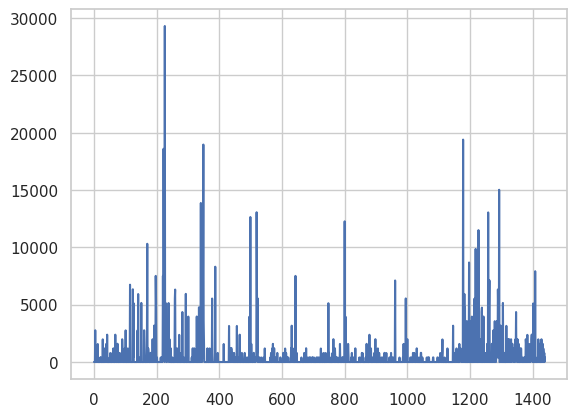

In [291]:
plt.plot(frequencies)

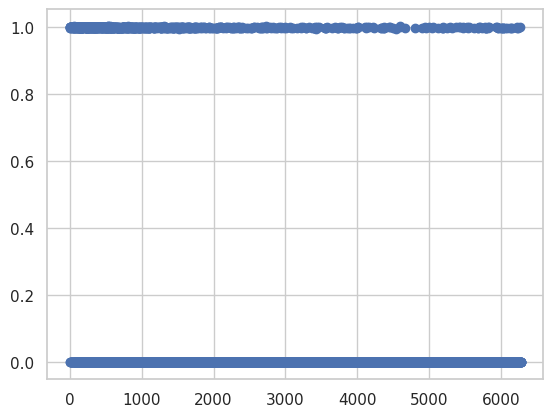

In [292]:
plt.plot(attention_score_freq, 'o')

In [293]:
indices_att_score = np.argsort(attention_score_freq)[::-1]

### Grad-SAM

In [74]:
batch_diseases, batch_counts, batch_labels = next(iter(dataloader_test))

In [75]:
logits, probas, x_out, loss = model.forward_decomposed(batch_diseases, batch_counts, batch_labels)
loss.backward()

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [80]:
model.blocks[layer].sa.attention_probas[0]

tensor([[[1.1314e-01, 1.3339e-11, 5.5280e-11,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.0540e-01, 3.9247e-10, 1.5867e-09,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.5209e-01, 3.5145e-08, 9.7491e-08,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[8.1727e-08, 4.4243e-10, 3.6773e-10,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [7.5264e-04, 5.3723e-05, 8.2521e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [6.3992e-08, 5.3206e-10, 2.0664e-10,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.000

In [48]:
mask.shape

torch.Size([200, 122, 122])

In [62]:
A.transpose(1, 2).transpose(2, 3)[mask].view(200, )

torch.Size([41486, 4])

In [43]:
H = torch.zeros(())
mask = model.padding_mask.detach().numpy()[indice_sentence].astype(bool)
n_real = np.sum(mask[0])
sentence = sentence[:n_real]
attention_probas_masked = attention_probas[mask].reshape(n_real, n_real)
for layer in range(train_model.n_layer):
    

    G = model.blocks[layer].sa.attention_probas.grad
    A = model.blocks[layer].sa.attention_probas
   
    H = A * nn.ReLU()(G) 




In [128]:
## definition of the attention score:
nb_distinct_diseases_tot = patient_list.get_nb_distinct_diseases_tot()
res = np.zeros(nb_distinct_diseases_tot)
frequencies = np.zeros(nb_distinct_diseases_tot)
for batch_sentence, batch_counts, batch_labels in dataloader_train:
    logits, probas, x_out, loss= model.forward_decomposed(batch_sentence, batch_counts, batch_labels)
    loss.backward()

    for indice_layer in range(train_model.n_layer):
        for indice_head in range(train_model.n_head):
            for indice_sentence in range(len(batch_sentence)):
                sentence = batch_sentence[indice_sentence]

                if len(sentence) != 0:

                    print(sentence)
        
                    A = model.blocks[indice_layer].sa.attention_probas[indice_sentence][indice_head]  
                    G = model.blocks[indice_layer].sa.attention_probas.grad[indice_sentence][indice_head]            
                    H = A * nn.ReLU()(G) 

                    mask = model.padding_mask[indice_sentence].to(bool)
                    n_real = torch.sum(mask[0])
                    sentence = sentence[:n_real]
                    frequencies[sentence] +=1

                    A_masked = H[mask].view(n_real, n_real).detach().numpy()
                    frequencies[sentence] +=1

                    vec = A_masked.sum(axis=1) / len(sentence)
                    res[sentence] = res[sentence]+ vec


res = res / train_model.n_layer / train_model.n_head


 

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([1227,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
tensor([ 124,  223, 1352,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


RuntimeError: shape '[0, 0]' is invalid for input of size 1089

In [127]:
len(sentence)

0

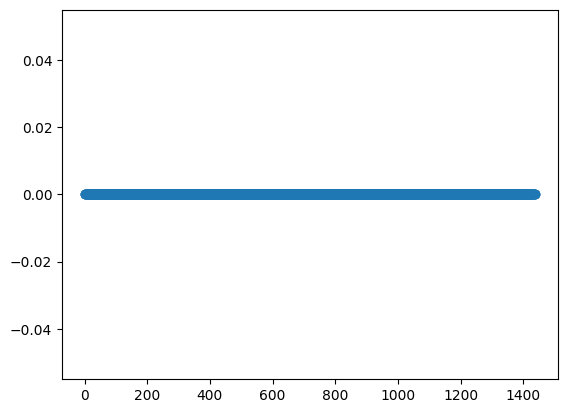

In [109]:
plt.plot(res, 'o')

In [95]:
mask_mat[sentence][:,sentence]

tensor([[ True, False, False, False, False],
        [False,  True, False, False, False],
        [False, False,  True, False, False],
        [False, False, False,  True, False],
        [False, False, False, False,  True]])

In [87]:
torch.tensor(sentence, sente)

ValueError: expected sequence of length 3 at dim 1 (got 1)

In [223]:
# Access gradients
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"Gradient of {name}: {param.grad}")

In [77]:
get_name(dataT, indices_att_score, decal=False)

In [ ]:
attention_score_freq = attention_score_diseases / frequencies
attention_score_freq[np.isnan(attention_score_freq)] = 0

In [ ]:
attention_score_freq

In [ ]:
np.argmax(attention_score_freq)

In [ ]:
plt.plot(attention_score_freq, 'o')

In [ ]:
attention_score_diseases[0]

In [ ]:
probas_weights = probas[:, :n_real]

In [ ]:
probas_weights[12].sum()

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 16))
sns.heatmap(probas_weights.detach().cpu(), cmap="YlGnBu", annot=False, fmt=".2f", cbar=True)

# Ajoutez des étiquettes pour les axes
plt.xlabel("Token")
plt.ylabel("Token")
plt.title("Self-Attention Matrix")

# Affichez le plot
plt.show()

In [ ]:
logits, probas, x_out = model.forward_decomposed(diseases_batch, counts_batch)


In [ ]:
attention_probas = model.list_attention_layers[1][1][0]

In [ ]:
attention_probas.sum()

In [ ]:

model.list_attention_layers

In [ ]:
train_model.dataT.indices_test, train_model.dataT.indices_train

In [ ]:
len(train_model.dataT.indices_test) + len( train_model.dataT.indices_train)

In [ ]:
f1, accuracy, auc_score, loss, proba_avg_zero, proba_avg_one, predicted_probas_list, true_labels_list = model.evaluate(dataloader_train)

In [ ]:
predicted_probs_ones = np.array(predicted_probas_list)[:, 1]
true_labels = np.array(true_labels_list)

In [ ]:
len(predicted_probs_ones)/20

In [ ]:
plt.hist(predicted_probs_ones, bins=100)

In [ ]:
prob_true, prob_pred = calibration_curve(true_labels_list, predicted_probs_ones, n_bins=80)
auc = calculate_roc_auc(true_labels_list, predicted_probs_ones)
# Tracer le graphique de calibration
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', label='Calibration Plot')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()

In [ ]:
hist, edges = np.histogram(predicted_probs_ones, bins=5)


In [ ]:
edges

In [ ]:
list_auc = []
for i in range(len(edges[:-1])):
    indices_bin = np.intersect1d(np.where(predicted_probs_ones>=edges[i]) , np.where(predicted_probs_ones<edges[i+1]) )
    bin_probas = predicted_probs_ones[indices_bin]
    bin_labels = true_labels[indices_bin]
    bin_auc = calculate_roc_auc(bin_labels, bin_probas)
    list_auc.append(bin_auc)


In [ ]:
accuracy

In [ ]:
list_auc

In [ ]:
i=0
indices_bin = np.intersect1d(np.where(predicted_probs_ones>=edges[i]) , np.where(predicted_probs_ones<edges[i+1]) )
bin_probas = predicted_probs_ones[indices_bin]
bin_labels = true_labels[indices_bin]
bin_auc = calculate_roc_auc(bin_labels, bin_probas)
list_auc.append(bin_auc)


In [ ]:
edges

In [ ]:
predicted_labels = (bin_probas>0.5).astype(int)

In [ ]:
bin_probas

In [ ]:
predicted_labels, bin_labels

In [ ]:
list_auc

In [ ]:

res = np.zeros(patient_list.get_nb_distinct_diseases_tot())
counts_ok = 0
counts = np.zeros(patient_list.get_nb_distinct_diseases_tot())
for k, patient in enumerate(patient_list):
    if k in train_model.dataT.indices_test:
        diseases_sentence = torch.tensor(patient.diseases_sentence).view(1, nb_max_distinct_disease)
        counts_sentence = torch.tensor(patient.counts_sentence).view(1, nb_max_distinct_disease)
        label_pred_patient = model.predict(diseases_sentence, counts_sentence)
        if label_pred_patient[0]==patient.SNP_label:
            counts_ok += 1
            res[patient.diseases_sentence] = res[patient.diseases_sentence] + 1
        counts[patient.diseases_sentence] = counts[patient.diseases_sentence] + 1

In [ ]:
logits, probas, attention_probas, attention_weights = model.forward_decomposed(diseases_sentence, counts_sentence)

In [ ]:
plt.plot(probas)

In [ ]:
def get_risk_pheno(data, labels, pheno_nb):
    labels_ac = labels[data[:,pheno_nb]==1]
    labels_deac = labels[data[:,pheno_nb]==0]
    proba_mut_ac = np.sum(labels_ac==1)/len(labels_ac)
    proba_mut_deac = np.sum(labels_deac==1)/len(labels_deac)
    ratio  = proba_mut_ac / proba_mut_deac
    return ratio
def get_pred_naive(data, labels, pheno_nb):
    labels_ac = labels[data[:,pheno_nb]==1]
    nb_ones_ac = np.sum(labels_ac==1)
    nb_zeros_ac = np.sum(labels_ac==0)
    return (1 if nb_ones_ac > nb_zeros_ac else 0)
get_risk_pheno = partial(get_risk_pheno, data, labels)
get_pred_naive = partial(get_pred_naive, data, labels)

In [ ]:
data

In [ ]:
odds_ratios = list(map(get_risk_pheno, phenos))
labels_pred_naive = list(map(get_pred_naive, phenos))

In [ ]:
preds = (np.array(probas) < 0.5).astype(int)

In [ ]:
1 - np.sum((preds-labels_pred_naive)**2)/1717

In [ ]:
data.shape

In [ ]:
len(patient_list)

In [ ]:
######### correlations with number zeros

In [ ]:
labels_res = []
nb_zeros_res = []
for patient in patient_list:
    diseases_sentence = torch.tensor(patient.diseases_sentence).view(1, nb_max_distinct_disease)
    counts_sentence = torch.tensor(patient.counts_sentence).view(1, nb_max_distinct_disease)
    label_pred_patient = model.predict(diseases_sentence, counts_sentence)
    nb_zeros = torch.sum(diseases_sentence==0)
    labels_res.append(label_pred_patient[0].item())
    nb_zeros_res.append(nb_zeros.item())


In [ ]:
nb_zeros_res = np.array(nb_zeros_res)
labels_res = np.array(labels_res)

In [ ]:
nb_zeros_res, labels_res

In [ ]:
zeros = np.unique(nb_zeros_res)
labels = [np.mean(labels_res[nb_zeros_res == nb_zero]) for nb_zero in zeros ]

In [ ]:
plt.plot(zeros, labels, 'o')

In [ ]:
################## Calibration plot ################
for patient in patient_list:
    

In [ ]:
count=0
for patient in patient_list:
    if patient.diseases_sentence[0]==0:
        count +=1

In [ ]:
file ='/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Pheno/Paul/ukbb_omop_rolled_up_depth_4_closest_ancestor.csv'
df_paul = pd.read_csv(file)

In [ ]:
eid_list = df_paul.eid
eid = eid_list[0]

In [ ]:
grouped = df_paul.groupby('eid')

In [ ]:
df = grouped.get_group(eid)

In [ ]:
unique_codes = list(df['concept_id'].values)
occurrences = list(df['condition_occurrence_count'].values)

disease_sentence = [code for code in unique_codes]
counts_sentence = [count for count in occurrences]

In [ ]:
unique_codes